# Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime, timedelta
from imblearn.under_sampling import TomekLinks

In [2]:
df = pd.read_json('logins.json')
df

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
df.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


In [5]:
df.isna().sum()

login_time    0
dtype: int64

In [6]:
df.nunique()

login_time    92265
dtype: int64

In [7]:
login_count = df.login_time.value_counts().to_frame()

In [8]:
login_count.login_time.value_counts()

1    91397
2      859
3        9
Name: login_time, dtype: int64

98% logged in once, the rest are 859 on two logged in and 9 recoreded a three times logged in

In [9]:
df.sort_values(by='login_time', inplace=True)

In [10]:
#adding in days and months
df['month']= df.login_time.dt.month_name()
df['month_count']= df.login_time.dt.month
df['week_count']= df.login_time.dt.week
df['day_count']= df.login_time.dt.day
df['weekday']= df.login_time.dt.day_name()
df.set_index(['login_time'], inplace = True)
df.head()

/var/folders/wk/1__f0f457zs4shb5sgjd_4x40000gn/T/ipykernel_99212/4147827521.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_count']= df.login_time.dt.week


,month,month_count,week_count,day_count,weekday
login_time,,,,,
1970-01-01 20:12:16,January,1,1,1,Thursday
1970-01-01 20:13:18,January,1,1,1,Thursday
1970-01-01 20:16:10,January,1,1,1,Thursday
1970-01-01 20:16:36,January,1,1,1,Thursday
1970-01-01 20:16:37,January,1,1,1,Thursday


In [11]:
df.groupby(['month_count', 'month'])['day_count'].count()


month_count  month   
1            January     21239
2            February    24673
3            March       33723
4            April       13507
Name: day_count, dtype: int64

<AxesSubplot: xlabel='month_count,month'>

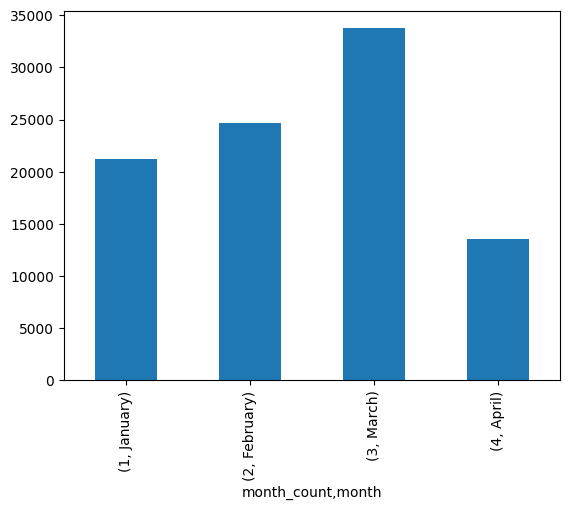

In [12]:
df.groupby(['month_count', 'month'])['day_count'].count().plot(kind='bar')

april has significant less login

In [13]:
df_day = df.groupby(['month_count', 'month', 'day_count'])['day_count'].count().to_frame(name='logins').reset_index()


In [14]:
df_day.groupby(['month_count', 'month'])['day_count'].count()


month_count  month   
1            January     31
2            February    28
3            March       31
4            April       13
Name: day_count, dtype: int64

April has only 13 days of login recorded 

In [15]:
df15 = df.drop(['month', 'month_count', 'week_count', 'weekday', 'day_count'], axis=1).copy()
df15['count'] = 1
df15 = df15.resample('15T', label='right', closed='right').sum()
df15.head()

,count
login_time,
1970-01-01 20:15:00,2
1970-01-01 20:30:00,6
1970-01-01 20:45:00,9
1970-01-01 21:00:00,7
1970-01-01 21:15:00,1


Text(0.5, 1.0, 'Login Count in 15mins Intervals')

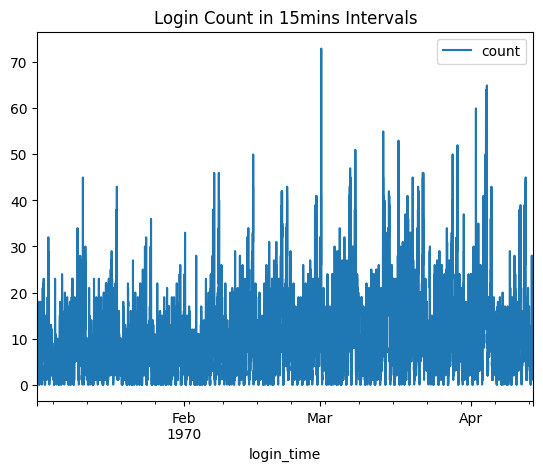

In [16]:
df15.plot()
plt.title('Login Count in 15mins Intervals')

Text(0.5, 1.0, 'Login Count by Day of Week')

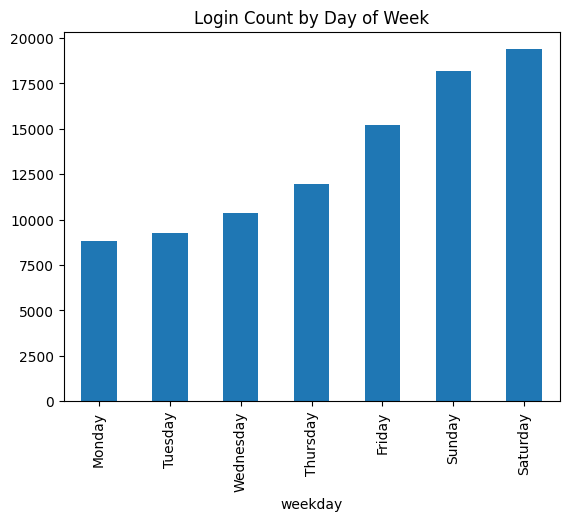

In [17]:
df.groupby(['weekday'])['weekday'].count().sort_values().plot(kind='bar')
plt.title("Login Count by Day of Week")

Login increases during the weekends

In [18]:
df15 = df15.reset_index()
df15['login_time'] = df15['login_time'].dt.time


In [19]:
df15.groupby(['login_time'])['count'].sum().sort_values()

login_time
08:00:00     176
08:30:00     179
08:15:00     190
07:45:00     192
07:00:00     215
            ... 
22:15:00    1634
23:00:00    1641
22:30:00    1654
01:45:00    1676
22:45:00    1682
Name: count, Length: 96, dtype: int64

Text(0.5, 1.0, 'Login Daily Peak')

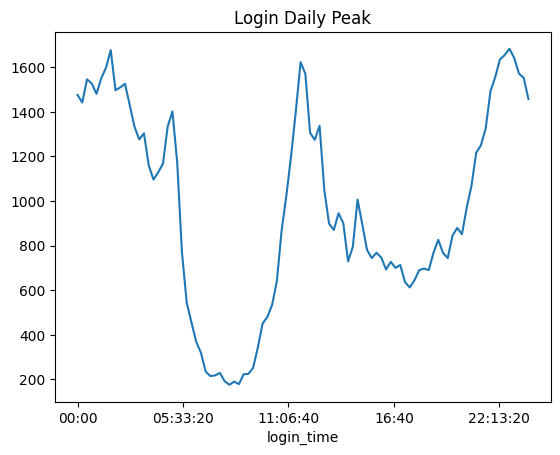

In [20]:
df15.groupby(['login_time'])['count'].sum().plot()
plt.title('Login Daily Peak')


Login peaks at around 11pm to 1AM, and plummets during 5:30am to 10am

# Part 2 - Experiment and Metric Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.


1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The key measure of success of this experiment in encouraging driver partners to serve both cities could be the increase in the number of drivers who are crossing the toll bridge to serve in the neighboring city.This metric could be measured by analyzing the data on the number of tolls collected from the toll bridge before and after the experiment. If the experiment is successful in encouraging driver partners to serve in both cities, there should be a significant increase in the number of drivers crossing the toll bridge, which would result in an increase in the number of tolls collected. This metric would indicate that the toll reimbursement incentive was effective in encouraging driver partners to serve both cities and promoting more fluid transportation between the two cities.


2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment

We could randomly assign a sample of driver partners to two groups. The treatment group would receive toll reimbursement, while the control group would not receive any reimbursement. The experiment would run for a specific period, for example, three months. During this period, we would collect data on the number of tolls paid by each driver and the number of trips they make across the toll bridge.

b) what statistical test(s) you will conduct to verify the significance of the observation

To determine the effectiveness of the proposed change, we could conduct a hypothesis test, specifically a A/B tests, to compare the mean number of tolls paid by the treatment and control groups. The null hypothesis would be that there is no difference in the mean number of tolls paid between the two groups.

c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

If the test shows that the mean number of tolls paid by the treatment group is significantly greater than the control group, we can conclude that the toll reimbursement incentive is effective in encouraging driver partners to serve in both cities. Based on this result, we would recommend that the city operations team continue to provide toll reimbursement as an incentive to driver partners to serve both cities.

However, it is important to note that other factors such as traffic congestion, time of day, and weather could influence the number of tolls paid and should be considered when interpreting the results. Additionally, it may be helpful to gather feedback from driver partners on their experience with the toll reimbursement incentive and to monitor any potential unintended consequences, such as an increase in congestion on the toll bridge.




Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do not need this information to answer Part 2.


# Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [21]:
df_ult = pd.read_json('ultimate_data_challenge.json')
df_ult

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [22]:
df_ult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [23]:
df_ult.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [24]:
df_ult.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

18.1% are outliers

In [25]:
df_ult1 = df_ult.dropna().copy()
df_ult1.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [26]:
print(df_ult1.signup_date.min(), df_ult1.signup_date.max())

2014-01-01 2014-01-31


In [27]:
print(df_ult1.last_trip_date.min(), df_ult1.last_trip_date.max())

2014-01-01 2014-07-01


### EDA On Each City

Text(0.5, 1.0, 'User Volume Of Each City')

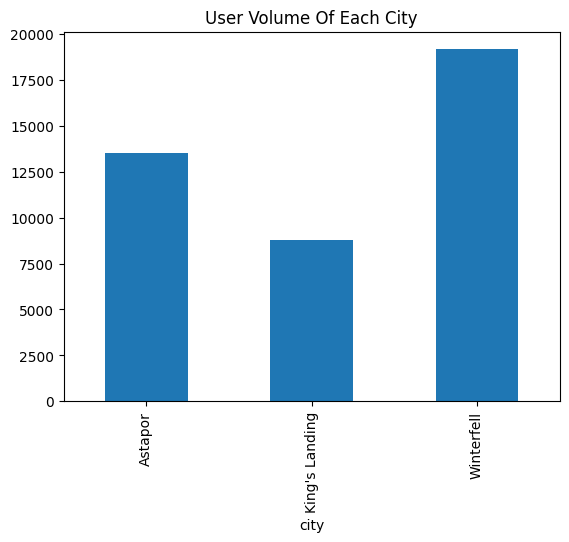

In [28]:
city_volume = df_ult1.groupby(['city'])['city'].count()
city_volume.plot(kind='bar')
plt.title('User Volume Of Each City')


<AxesSubplot: xlabel='avg_rating_of_driver'>

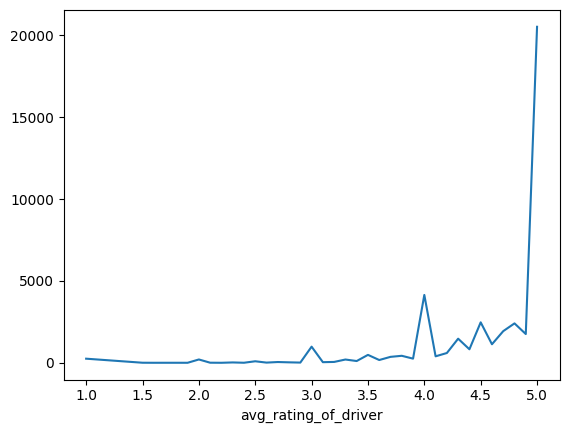

In [29]:
avg_rating_of_driver = df_ult1.groupby(['avg_rating_of_driver'])['avg_rating_of_driver'].count()
avg_rating_of_driver.plot()

<AxesSubplot: xlabel='avg_rating_by_driver'>

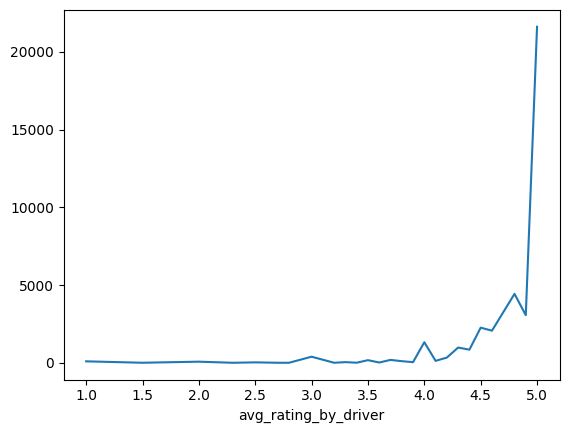

In [30]:
avg_rating_by_driver = df_ult1.groupby(['avg_rating_by_driver'])['avg_rating_by_driver'].count()
avg_rating_by_driver.plot()

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


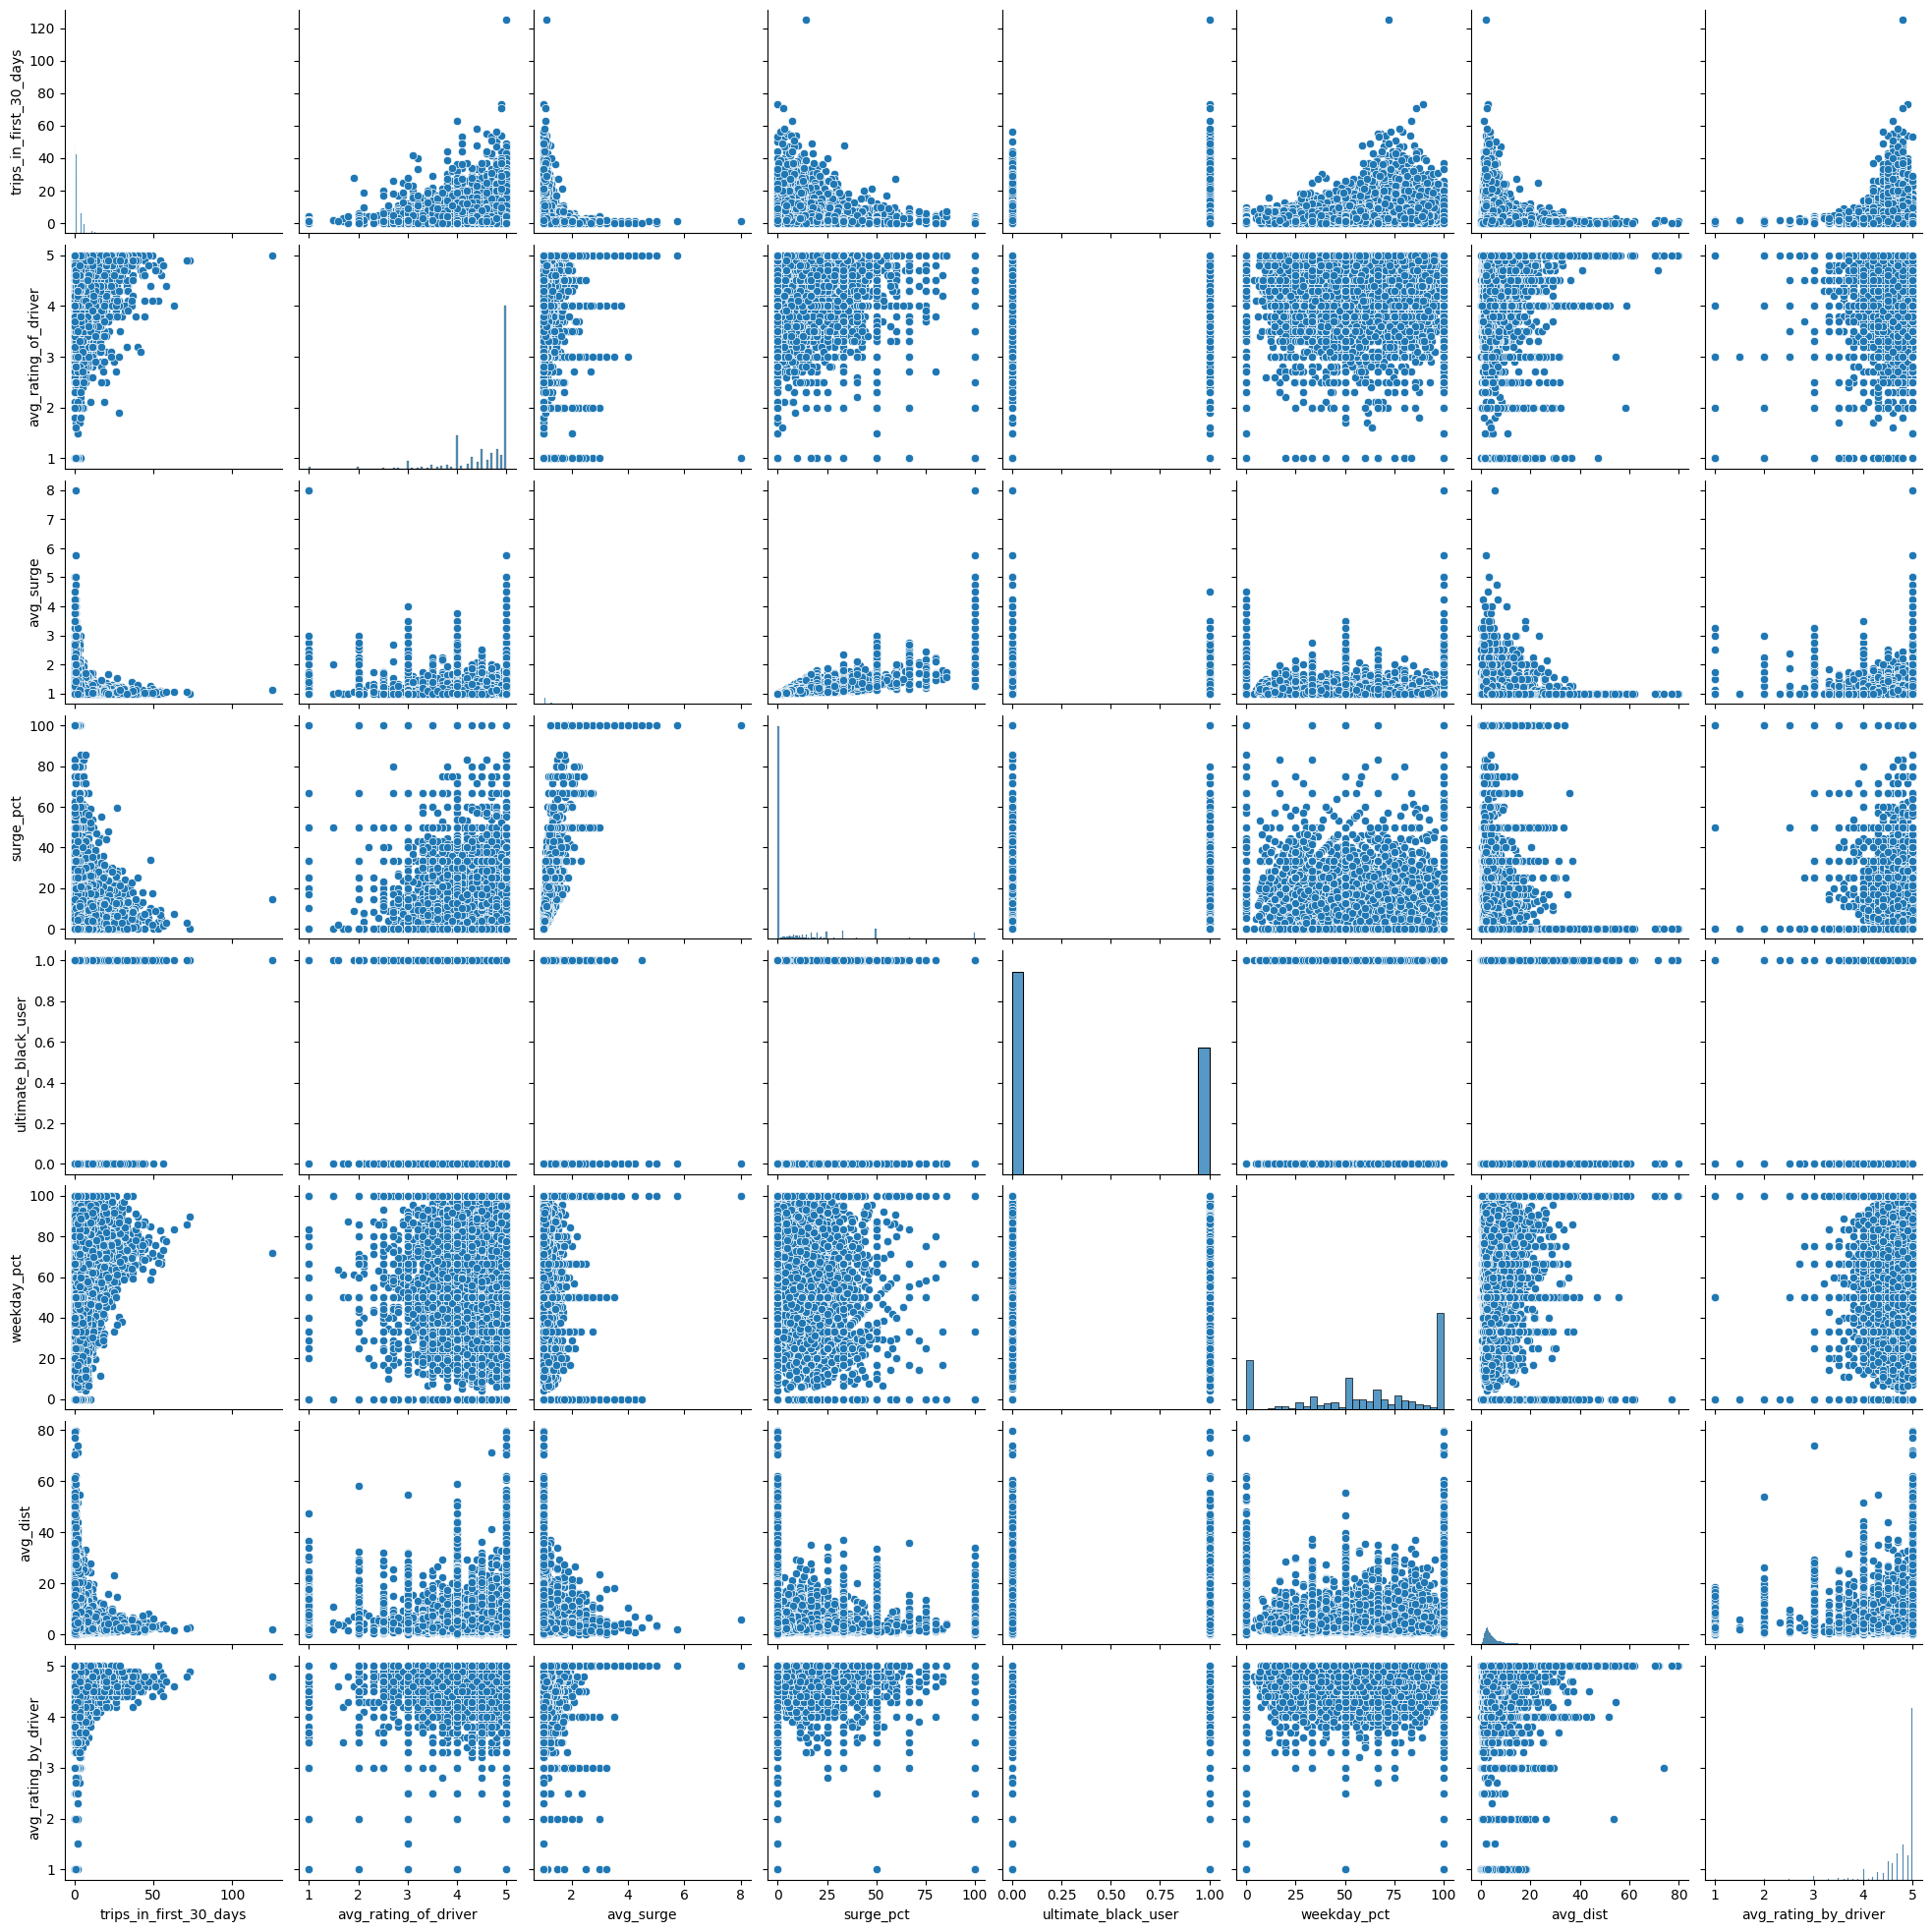

In [31]:
sns.pairplot(df_ult1)

In [32]:
df_ult1['trips_in_first_30_days'].sort_values(ascending=False).head()

18514    125
99        73
3030      71
29070     63
48804     58
Name: trips_in_first_30_days, dtype: int64

In [33]:
# Rating of Driver of Each City
df_ult1.groupby(['city'])['avg_rating_of_driver'].mean()

city
Astapor           4.630883
King's Landing    4.707943
Winterfell        4.532514
Name: avg_rating_of_driver, dtype: float64

In [34]:
# Rating by Driver of Each City
df_ult1.groupby(['city'])['avg_rating_by_driver'].mean()

city
Astapor           4.794766
King's Landing    4.851897
Winterfell        4.728976
Name: avg_rating_by_driver, dtype: float64

In [35]:
# Average Distance of Each City
df_ult1.groupby(['city'])['avg_dist'].mean()

city
Astapor           5.151244
King's Landing    5.714379
Winterfell        5.561285
Name: avg_dist, dtype: float64

In [36]:
# Weekday Percentage of Each City
df_ult1.groupby(['city'])['weekday_pct'].mean()

city
Astapor           60.702265
King's Landing    63.480046
Winterfell        60.625484
Name: weekday_pct, dtype: float64

In [37]:
print('Percentage of Ultimate Black User: {:}'.format((len(df_ult1[df_ult1.ultimate_black_user==True])/len(df_ult1))*100))

Percentage of Ultimate Black User: 38.40994088551092


In [38]:
city_riders = pd.DataFrame(df_ult1.groupby(['city'])['city'].count())
city_riders.columns = ["riders"]
city_riders

,riders
city,
Astapor,13509
King's Landing,8775
Winterfell,19161


Text(0.5, 1.0, 'Type of Phone Used by Rider')

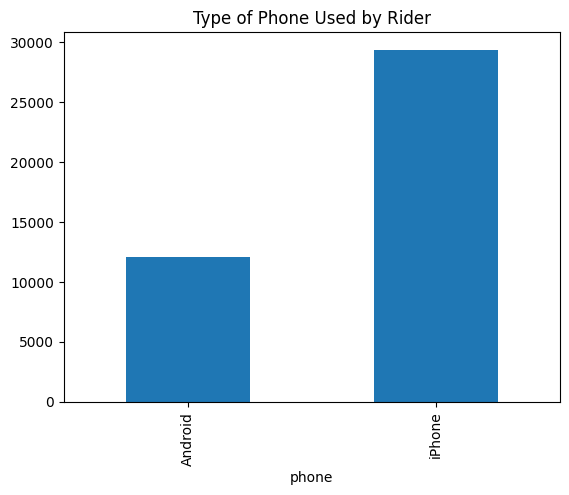

In [39]:
# Type of Phone Used by Rider
df_ult1.groupby(['phone'])['phone'].count().plot(kind='bar')
plt.title('Type of Phone Used by Rider')

In [40]:
## Convert to Datetime
df_ult1.last_trip_date = pd.to_datetime(df_ult1.last_trip_date)
df_ult1.last_trip_date = df_ult1.last_trip_date.dt.normalize()

In [41]:
df_ult1['retained'] = (df_ult1['last_trip_date'] >= '2014-06-01')*1
print(df_ult1[['retained','last_trip_date']].head())
print(df_ult1.retained.value_counts())

   retained last_trip_date
0         1     2014-06-17
1         0     2014-05-05
2         0     2014-01-07
3         1     2014-06-29
4         0     2014-03-15
0    24410
1    17035
Name: retained, dtype: int64


In [42]:
print(len(df_ult1.retained == 0) / len(df_ult1.retained == 1))

1.0


In [43]:
print('Percentage of Active Riders: {}'.format(sum(df_ult1['retained'] == 1) / len(df_ult1) * 100)) 

Percentage of Active Riders: 41.102666184099405


In [44]:
plt.figure(figsize=(20,20))
corr = df_ult1.corr()
fig = px.imshow(corr)
fig.show()

/var/folders/wk/1__f0f457zs4shb5sgjd_4x40000gn/T/ipykernel_99212/1455200394.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_ult1.corr()


<Figure size 2000x2000 with 0 Axes>

In [47]:
corr['retained'].sort_values(ascending=False)

retained                  1.000000
ultimate_black_user       0.217365
trips_in_first_30_days    0.198816
surge_pct                 0.011126
weekday_pct               0.010423
avg_surge                -0.004185
avg_rating_of_driver     -0.011829
avg_rating_by_driver     -0.034720
avg_dist                 -0.089498
Name: retained, dtype: float64

* 18.1% outliers are removed

* First signup date is at 2014-01-01, and last signup date is at 2014-01-31

* Winterfell has the most user, and King's Landing has the least

* Most Ratings Of / By driver are close to 5 stars rating

* King's Landing has the best rating OF driver 4.7, Astapor came in second 4.6, and Winterfell came in last with 4.5

* King's Landing also got the best rating BY driver 4.8, Astapor scored a 4.79, and Winterfell scored a 4.72

* iPhone riders doubled the amount of Andriod riders

* 41.1% of riders has at least one trip within the last 30 days

* ultimate_black_user has the highest correlated with retained users

In [48]:
# A final version of df, dropping featuers will not be used in modeling
final_df = df_ult1.drop(['signup_date', 'last_trip_date'], axis = 1)

In [50]:
final_df

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...
49993,Astapor,3,4.8,1.11,iPhone,11.1,True,55.6,2.53,4.7,1
49994,Astapor,1,4.6,1.44,iPhone,37.5,False,25.0,2.25,4.5,0
49995,King's Landing,0,5.0,1.00,iPhone,0.0,False,100.0,5.63,4.2,1
49997,Winterfell,0,5.0,1.00,Android,0.0,True,100.0,3.86,5.0,0


In [51]:
from pycaret.classification import *

In [55]:
exp1 = setup(data=final_df, target='retained', feature_selection = True, session_id=123, fix_imbalance = True, fix_imbalance_method=TomekLinks())

,Description,Value
0,Session id,123
1,Target,retained
2,Target type,Binary
3,Original data shape,"(41445, 11)"
4,Transformed data shape,"(39026, 3)"
5,Transformed train set shape,"(26592, 3)"
6,Transformed test set shape,"(12434, 3)"
7,Ordinal features,1
8,Numeric features,7
9,Categorical features,2


In [56]:
exp1.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [58]:
top3 = compare_models(
    turbo=True,
    n_select=3,
    sort='AUC',
    exclude=['rbfsvm', 'gpc', 'mlp']
)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:41:38
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7196,0.7611,0.6317,0.6682,0.6494,0.4161,0.4166,1.3670
lightgbm,Light Gradient Boosting Machine,0.7189,0.7606,0.6414,0.6636,0.6522,0.4165,0.4167,0.0860
gbc,Gradient Boosting Classifier,0.7159,0.7603,0.6677,0.6506,0.6590,0.4156,0.4158,0.2020
xgboost,Extreme Gradient Boosting,0.7163,0.7564,0.6371,0.6607,0.6486,0.4108,0.4111,0.1790
ada,Ada Boost Classifier,0.7105,0.7493,0.6899,0.6366,0.6621,0.4096,0.4107,0.1200
knn,K Neighbors Classifier,0.6850,0.7152,0.6195,0.6162,0.6178,0.3499,0.3499,0.0780
rf,Random Forest Classifier,0.6666,0.6991,0.6063,0.5922,0.5992,0.3138,0.3139,0.4190
nb,Naive Bayes,0.6176,0.6918,0.7545,0.5244,0.6187,0.2594,0.2769,0.0630
qda,Quadratic Discriminant Analysis,0.6252,0.6918,0.7470,0.5316,0.6211,0.2708,0.2862,0.0720
et,Extra Trees Classifier,0.6742,0.6724,0.5755,0.6099,0.5921,0.3212,0.3217,0.3550


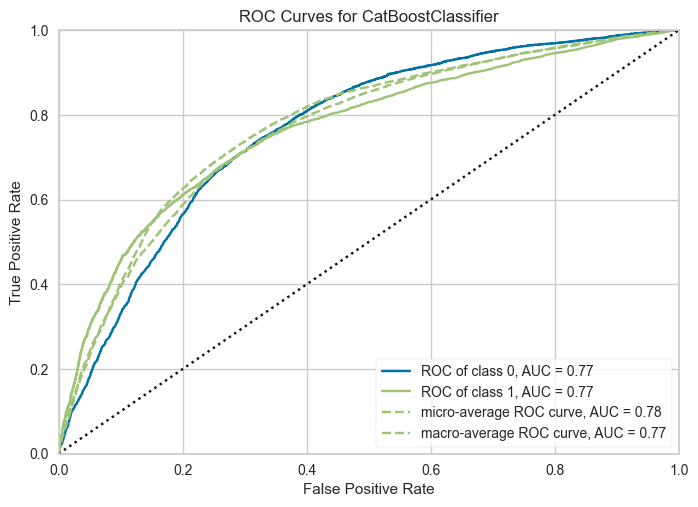

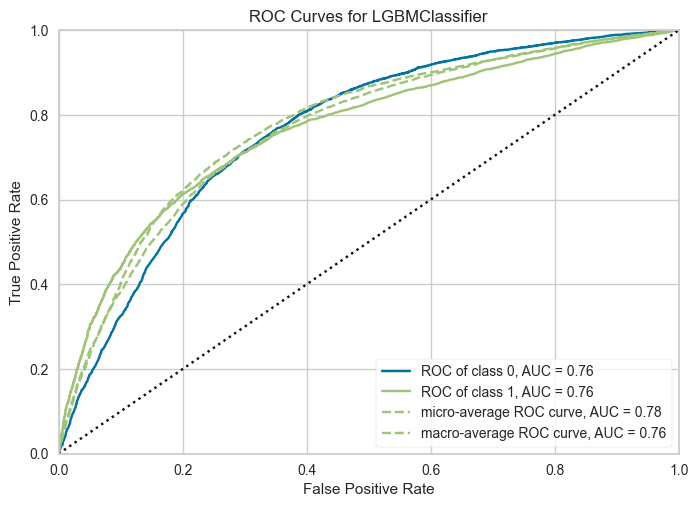

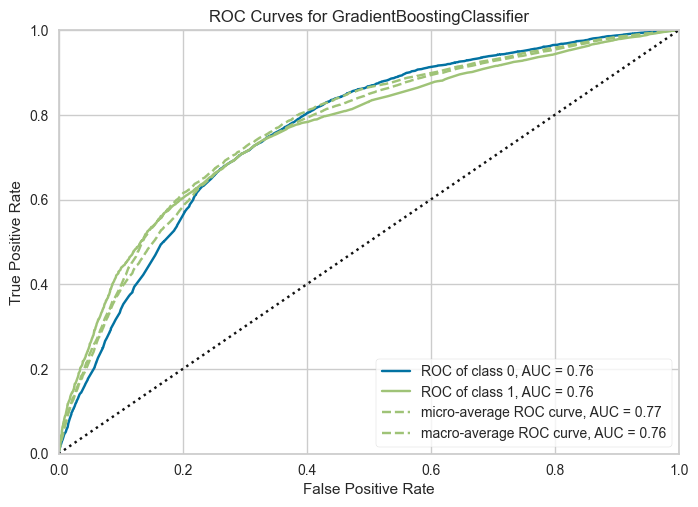

In [59]:
for model in top3:
    exp1.plot_model(model)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:46:32
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7123,0.7582,0.6262,0.6576,0.6415,0.4014,0.4018
1,0.7122,0.7561,0.6133,0.6615,0.6365,0.3988,0.3996
2,0.7308,0.7761,0.6435,0.6830,0.6626,0.4390,0.4395
3,0.7280,0.7715,0.6351,0.6814,0.6574,0.4324,0.4331
4,0.7173,0.7514,0.6233,0.6670,0.6444,0.4103,0.4109
5,0.7342,0.7733,0.6443,0.6888,0.6658,0.4456,0.4463
6,0.7225,0.7622,0.6334,0.6723,0.6523,0.4218,0.4223
7,0.7056,0.7416,0.6203,0.6486,0.6341,0.3881,0.3883
8,0.7215,0.7633,0.6530,0.6641,0.6585,0.4234,0.4234


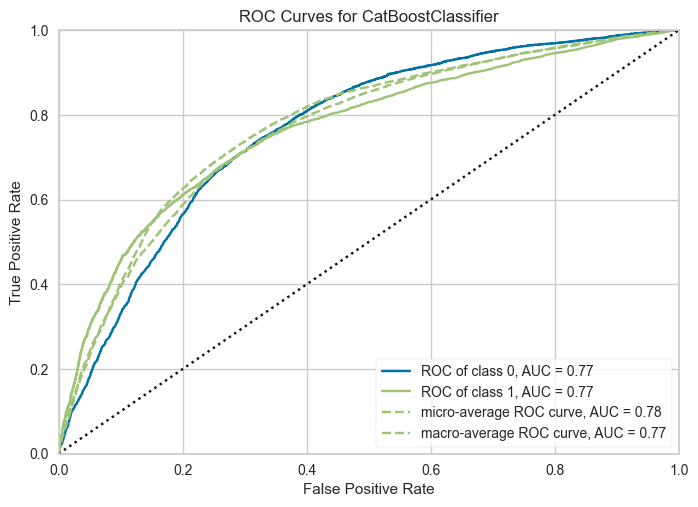

In [62]:
catboost = exp1.create_model('catboost')
plot_model(catboost)

In [63]:
tuned_catboost = tune_model(catboost, optimize = 'AUC')
tuned_catboost

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:47:43
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7136,0.7611,0.6387,0.6558,0.6471,0.4063,0.4064
1,0.7173,0.7568,0.6250,0.6664,0.6450,0.4106,0.4112
2,0.7308,0.7768,0.6518,0.6798,0.6655,0.4404,0.4407
3,0.7291,0.7733,0.6418,0.6806,0.6606,0.4355,0.4360
4,0.7191,0.7533,0.6426,0.6632,0.6527,0.4170,0.4171
5,0.7270,0.7732,0.6586,0.6709,0.6647,0.4345,0.4345
6,0.7232,0.7658,0.6510,0.6672,0.6590,0.4261,0.4262
7,0.7073,0.7415,0.6370,0.6463,0.6416,0.3943,0.3944
8,0.7235,0.7636,0.6538,0.6672,0.6605,0.4274,0.4274


Fitting 10 folds for each of 10 candidates, totalling 100 fits


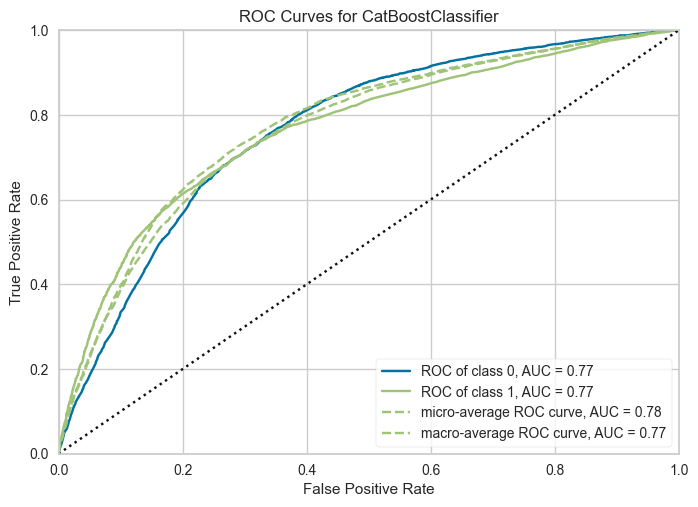

In [64]:
plot_model(tuned_catboost)

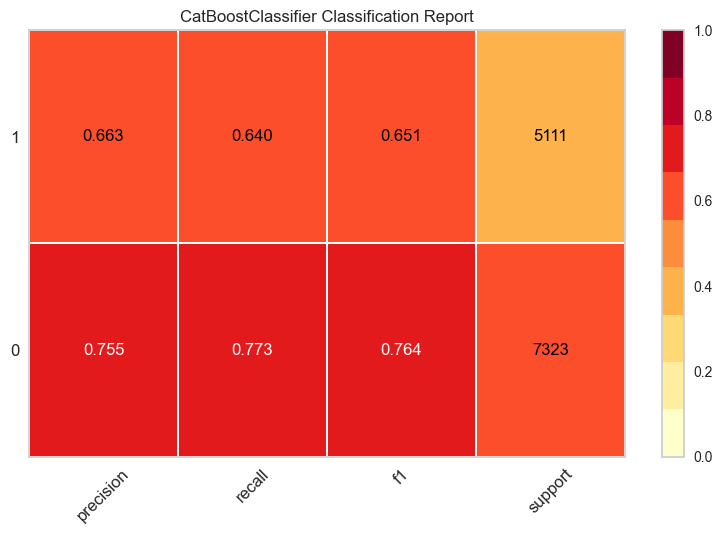

In [65]:
plot_model(tuned_catboost, plot='class_report')

In [66]:
predict_model(tuned_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7181,0.7657,0.6400,0.6627,0.6511,0.4148,0.4149


,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,prediction_label,prediction_score
29011,Winterfell,16,4.8,1.01,iPhone,2.3,True,89.800003,2.70,4.9,1,1,0.7774
29012,King's Landing,2,3.0,1.00,iPhone,0.0,False,0.000000,4.93,4.8,1,0,0.7789
29013,Astapor,1,5.0,1.00,Android,0.0,True,100.000000,3.40,5.0,0,0,0.7417
29014,Astapor,1,5.0,2.50,iPhone,100.0,False,100.000000,3.65,5.0,0,0,0.7387
29015,Winterfell,0,5.0,1.00,iPhone,0.0,False,100.000000,1.06,5.0,1,0,0.8362
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41440,Winterfell,3,5.0,1.00,iPhone,0.0,True,100.000000,10.47,5.0,0,0,0.7423
41441,Astapor,7,4.8,1.02,iPhone,4.2,False,58.299999,2.46,4.6,1,1,0.8588
41442,Winterfell,3,5.0,1.05,Android,9.1,False,72.699997,2.69,4.8,0,1,0.8067
41443,Astapor,4,4.2,1.03,iPhone,10.5,True,89.500000,3.05,4.8,1,1,0.7238


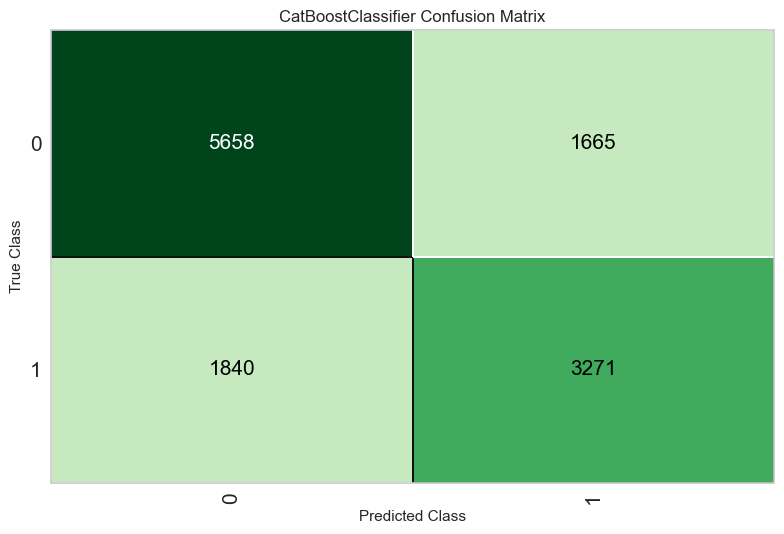

In [67]:
plot_model(tuned_catboost, plot='confusion_matrix')

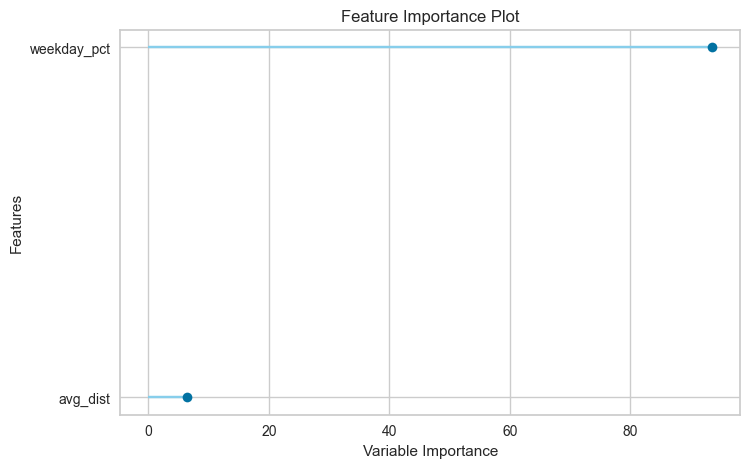

In [68]:
plot_model(tuned_catboost, plot='feature')

2. CatBoost is a popular baseline machine learning algorithm for binary classification tasks. It is a gradient boosting algorithm that handles categorical data well and has built-in support for dealing with missing values. Additionally, it has been shown to perform well on a variety of datasets. As for alternative approaches, ohter machine learning algorithms that could be used to this task include lightgbm, gbc, xgboost, RandomForrest. These models each have their own advantages and disadvantages. Based on our result, weekday_pct is the most infuential feature on the model, the final metrics for the tuned model resulted an accuracy 0.7181 and an AUC score of 0.7657.

3. To improve rider retention, Ultimate should reimburse all toll costs for three months. During this period, we would collect data on the number of tolls paid by each driver and the number of trips they make across the toll bridge.